In [22]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette())

import pandas as pd
import pickle
from tqdm.notebook import tqdm
from plotnine import *
import igraph
import itertools
from functools import reduce
from scipy.stats import chisquare

from mcmcmd.samplers import *
from mcmcmd.tests import *

# Helper functions

In [23]:
def b_nk(n, k, A, B, B_terms):
    if (n, k) not in B:
        if n == k:
            B_terms[(n, k)] = onp.array([1])
            B[(n, k)] = 1
        else:
            s = onp.arange(1, n-k+1)
            B_terms[(n, k)] = ((2**k-1)**s * 2**(k*(n-k-s)) * A[n-k-1, :][s-1]).astype('int')
            B[(n, k)] = int(B_terms[(n, k)].sum())
    return B[(n, k)]

# Sample a DAG uniformly using the enumeration method from Kuipers and Moffa 2013.
def sample_uniform_DAG(num_nodes, rng=None):
    if rng is None:
        rng = onp.random.default_rng()

    A = onp.identity(num_nodes, dtype='int')
    B = {}
    B_terms = {}

    for n in range(1, num_nodes+1):
        for k in range(1, n+1):
            A[n-1, k-1] = comb(n, k, exact=True) * b_nk(n, k, A, B, B_terms)

    # A[n-1, k-1] is the number of DAGs with n nodes and k outpoints (roots).
    
    K = [] # List of k
    n = num_nodes
    
    r = rng.choice(A[n-1, :].sum())+1
    
    k = 1
    while r > A[n-1, k-1]:
        r -= A[n-1, k-1]
        k += 1
    K.append(k)

    r = int(onp.ceil(r/comb(n, k, exact=True)))
    m = n-k
    while m > 0:
        s = 1
        t = int((2**k - 1)**s * 2**(k*(m-s)) * A[m-1, s-1])
        while r > t:
            r -= t
            s += 1
            t = (2**k - 1)**s * 2**(k*(m-s)) * A[m-1, s-1]
        
        r = int(onp.ceil(r/(comb(m, s, exact=True) * t/A[m-1, s-1])))
        
        n = m
        k = s
        m = n-k
        K.append(k)

    Q = onp.zeros(shape=(num_nodes, num_nodes), dtype='int')
    j = K[-1]
    for i in range(len(K)-1, 0, -1):
        for l in range(j-K[i], j):
            bln_zeroCol = True
            while bln_zeroCol:
                for m in range(j, j+K[i-1]):
                    Q[m, l] = rng.choice(2)
                    if Q[m, l] == 1:
                        bln_zeroCol = False
                        
            for m in range(j+K[i-1], num_nodes):
                Q[m, l] = rng.choice(2)
        j += K[i-1]

    node_labels = rng.permutation(num_nodes)
    Q = Q[node_labels, :][:, node_labels]
    return Q

# Check if DAG is cyclic
def isCyclic(adj_matrix):
    if onp.diag(adj_matrix).sum() != 0:
        return True
    
    num_nodes = adj_matrix.shape[0]
    nodes = onp.arange(num_nodes)
    
    done = False
    notLeaf = adj_matrix.sum(1).astype('bool')
    while not done: 
        adj_matrix = adj_matrix[notLeaf, :][:, notLeaf]
        notLeaf = adj_matrix.sum(1).astype('bool')
        if notLeaf.sum() == len(notLeaf):
            done = True
    
    return adj_matrix.shape[0] != 0

# Sample from likelihood
def sample_DAG_data(adj_matrix, N=1, epsilon=1, rng=None):
    if rng is None:
        rng = onp.random.default_rng()
    
    num_nodes = adj_matrix.shape[0]
    nodes = onp.arange(num_nodes)

    x = onp.zeros(shape=(N, num_nodes))
    node_gen = onp.zeros(num_nodes)
    node_gen_count = 0

    isRoot = ~adj_matrix.sum(0).astype('bool')
    roots = nodes[isRoot]
    if len(roots) == 0:
        raise ValueError('adj_matrix encodes a cyclic graph!')

    children = onp.zeros(num_nodes, dtype='int')
    for r in roots:
        x[:, r] = rng.normal(0, epsilon, size = N)
        node_gen[r] = 1
        node_gen_count += 1
        children += adj_matrix[r, :]

    while node_gen_count < num_nodes:
        for child in nodes[children.astype('bool')]:
            if node_gen[child] == 1:
                raise ValueError('adj_matrix encodes a cyclic graph!')
            parents = nodes[adj_matrix[:, child] == 1]
            if node_gen[parents].sum() == len(parents):
                x[:, child] = rng.normal(x[:, parents].sum(1), epsilon, size = N)
                node_gen[child] = 1
                node_gen_count += 1
                children += adj_matrix[child, :]
                children[child] = 0
    return x

# Calculate log-evidence
def log_evidence(X, adj_matrix, epsilon):
    num_nodes = adj_matrix.shape[0]
    n, p = X.shape
    mu = (adj_matrix.T.reshape(1, num_nodes, num_nodes) @ X.reshape(n, p, 1)).sum(2)
    return norm.logpdf(loc=mu, scale=epsilon, x=X).sum()

# Modify an edge
def changeEdge_DAG(adj_matrix, i, j, change_type='toggle'):
    assert change_type in ['toggle', 'reverse']
    proposal = adj_matrix.copy()
    
    if i == -1 and j == -1:
        return proposal

    if change_type == 'reverse':
        if adj_matrix[i, j] == 1:
            proposal[i, j] = 0
            proposal[j, i] = 1
        elif adj_matrix[i, j] == 0:
            raise ValueError('Cannot reverse non-existent edge')
        else:
            raise ValueError('adj_matrix is non-binary')
    else:
        if adj_matrix[i, j] == 1:
            proposal[i, j] = 0
        elif adj_matrix[i, j] == 0:
            proposal[i, j] = 1
        else:
            raise ValueError('adj_matrix is non-binary')
    
    return proposal

# Enumerate all DAGs that can be reached by adding/deleting/reversing edges. Optionally sample one uniformly at random
def neighbors_DAG(adj_matrix, return_sample=False, rng=None):
    if rng is None:
        rng = onp.random.default_rng()
        
    nodes = onp.arange(adj_matrix.shape[0])
    edges = [(i, j) for i, j in itertools.product(nodes, nodes)]
    edges += [(-1, -1)] # no change

    lst_proposals = []
    for i, j in edges:

        # No change
        if i == -1 and j == -1:
            lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})
        
        # Skip diagonals
        if i == j:
            continue
        
        # Add DAG reached by toggling edge i,j
        proposal = changeEdge_DAG(adj_matrix, i, j, change_type='toggle')
        if not isCyclic(proposal):
            lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})
        
        # Add DAG reached by reversing edge i,j
        if adj_matrix[i, j] == 1:
            proposal = changeEdge_DAG(adj_matrix, i, j, change_type='reverse')
            if not isCyclic(proposal):
                lst_proposals.append({'i':i, 'j':j, 'change_type':'reverse'})

    k = len(lst_proposals)
    if return_sample == True:
        args = rng.choice(lst_proposals)
        proposal = changeEdge_DAG(adj_matrix, **args)
        return k, proposal
    else:
        return k

def count_sample_DAG(z):
    z = z.astype('int').astype('str')
    z = onp.hsplit(z, z.shape[1])
    z = reduce(onp.char.add, z)
    vals, counts = onp.unique(z, return_counts = True)
    return vals, counts

# Setup

For simplicity, assume the model parameters are fixed. Given graph structure $\mathcal{G}$, data $\mathbf{X}$, and $\epsilon=1$, let the root nodes be standard normal random variables
\begin{equation}
    x_{r} \sim \mathcal{N}(0, \epsilon^2)
\end{equation}
and let each child node have mean equal to the sum of their parents
\begin{equation}
    x_{j}|\mathbf{pa}(x_{j}) \sim \mathcal{N}(\sum_{z \in \mathbf{pa}(x_{j})} z, \epsilon^2)
\end{equation}

The model evidence is
\begin{equation}
    p(\mathbf{X}|\mathcal{G}) = \prod_{i=1}^{n} \prod_{j=1}^{p} p(x_{ij}|\mathbf{pa}(x_{ij})) 
\end{equation}

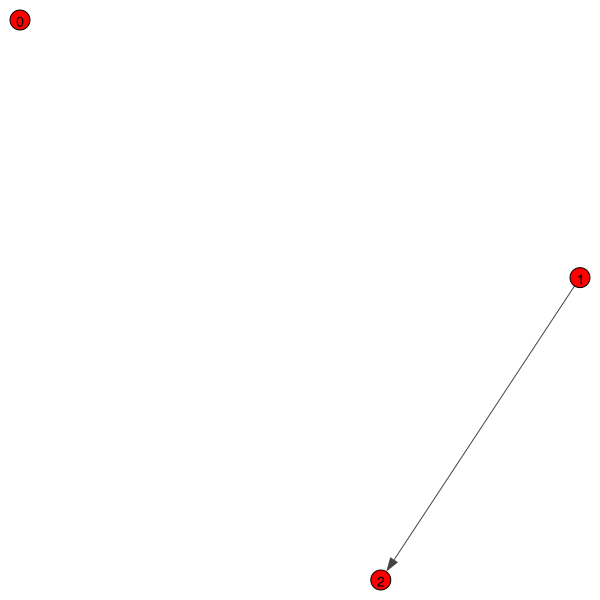

In [24]:
rng = onp.random.default_rng()
num_nodes = 3
Q = sample_uniform_DAG(num_nodes)
g=igraph.Graph.Adjacency(Q.tolist())
g.vs['label'] = onp.arange(num_nodes)
igraph.plot(g)

In [25]:
class linear_gaussian_sampler(model_sampler):
    def __init__(self, **kwargs):
        self._N = 1
        self._num_nodes = 3
        self._epsilon = 1
        super().__init__(**kwargs)
        
        # Check inputs
        for attr in ['_N', '_num_nodes', '_epsilon']:
            assert hasattr(self, attr)
        
        assert type(self._N).__name__ == 'int'
        assert type(self._num_nodes).__name__ == 'int'
        assert self._epsilon > 0
        
#         self._MH = []
        
        pass

    @property
    def sample_dim(self):
        return self._N*self._num_nodes + self._num_nodes**2

    # Exclude indices corresponding to the diagonal of adj matrix
    @property
    def theta_indices(self):
        ind = onp.arange(self._N*self._num_nodes, self.sample_dim)
        ind_diag = onp.arange(0, self._num_nodes**2, self._num_nodes+1)
        return ind[onp.setdiff1d(onp.arange(self._num_nodes**2), onp.arange(0, self._num_nodes**2, self._num_nodes+1))]

    def drawPrior(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        self._G = sample_uniform_DAG(self._num_nodes, rng)
        return self._G.reshape(1, self._num_nodes**2).flatten()

    def drawLikelihood(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        self._X = sample_DAG_data(self._G, self._N, self._epsilon, rng)
        return self._X.reshape(1,self._N*self._num_nodes).flatten()

    def drawPosterior(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        
        num_neighbors, proposal = neighbors_DAG(self._G, True, rng)
        num_neighbors_proposal = neighbors_DAG(proposal)
        MH = num_neighbors/num_neighbors_proposal * onp.exp(log_evidence(self._X, proposal, self._epsilon) - log_evidence(self._X, self._G, self._epsilon))

#         self._MH.append(MH)

        if rng.uniform() <= MH:
            self._G = proposal
        return self._G.reshape(1, self._num_nodes**2).flatten()


class linear_gaussian_sampler_error_1(linear_gaussian_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = onp.random.Generator(onp.random.MT19937())
        
        num_neighbors, proposal = self.neighbors_DAG(self._G, True, rng)
        num_neighbors_proposal = self.neighbors_DAG(proposal)
        MH = num_neighbors/num_neighbors_proposal * onp.exp(log_evidence(self._X, proposal, self._epsilon) - log_evidence(self._X, self._G, self._epsilon))

        if rng.uniform() <= MH:
            self._G = proposal
        return self._G.reshape(1, self._num_nodes**2).flatten()
    
    # Enumerate all DAGs that can be reached by adding/deleting/reversing edges. 
    # Error: double-count the number of DAGs reached by reversing edges (accidentally reversing non-edges and counting the result)
    def neighbors_DAG(self, adj_matrix, return_sample=False, rng=None):
        if rng is None:
            rng = onp.random.default_rng()

        nodes = onp.arange(adj_matrix.shape[0])
        edges = [(i, j) for i, j in itertools.product(nodes, nodes)]
        edges += [(-1, -1)] # no change

        lst_proposals = []
        for i, j in edges:

            # No change
            if i == -1 and j == -1:
                lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})

            # Skip diagonals
            if i == j:
                continue

            # Add DAG reached by toggling edge i,j
            proposal = changeEdge_DAG(adj_matrix, i, j, change_type='toggle')
            if not isCyclic(proposal):
                lst_proposals.append({'i':i, 'j':j, 'change_type':'toggle'})

            # Add DAG reached by reversing edge i,j
            rev_count = 0
            if adj_matrix[i, j] == 1:
                proposal = changeEdge_DAG(adj_matrix, i, j, change_type='reverse')
                if not isCyclic(proposal):
                    lst_proposals.append({'i':i, 'j':j, 'change_type':'reverse'})
                    rev_count += 1

        k = len(lst_proposals) + rev_count # Error
        if return_sample == True:
            args = rng.choice(lst_proposals)
            proposal = changeEdge_DAG(adj_matrix, **args)
            return k, proposal
        else:
            return k

In [28]:
num_trials = 20
num_samples = 2e3
f_kernel = lambda X, Y: rbf_kernel(X, Y, tau=1)

tmp = linear_gaussian_sampler()
tmp.set_nproc(5)

rej_chisq = 0
rej_geweke = 0
rej_mmd_wb = 0
for _ in tqdm(range(num_trials)):
    samples_mc = tmp.sample_mc(num_samples)
    samples_sc = tmp.sample_sc(num_samples)

    vals_sc, counts_sc = count_sample_DAG(samples_sc[onp.arange(0, int(num_samples), 1), :][:, tmp.theta_indices])
    rej_chisq += chisquare(counts_sc).pvalue <= 0.05
    rej_geweke += geweke_test(tmp.test_functions(samples_mc[:, tmp.theta_indices]), tmp.test_functions(samples_sc[:, tmp.theta_indices]), l=0.08)['result'].max()
    rej_mmd_wb += mmd_wb_test(samples_mc[:2000][:, tmp.theta_indices], samples_sc[onp.arange(0, int(num_samples), int(num_samples/2000)), :][:, tmp.theta_indices], f_kernel)['result']

print(f'Chisq Rejection Rate: {rej_chisq}')
print(f'Geweke Rejection Rate: {rej_geweke}')
print(f'MMD-WB Rejection Rate: {rej_mmd_wb}')


Chisq Rejection Rate: 19
Geweke Rejection Rate: 2
MMD-WB Rejection Rate: 1


In [29]:
num_trials = 20
num_samples = 2e3
f_kernel = lambda X, Y: rbf_kernel(X, Y, tau=1)

tmp = linear_gaussian_sampler_error_1()
tmp.set_nproc(5)

rej_chisq = 0
rej_geweke = 0
rej_mmd_wb = 0
for _ in tqdm(range(num_trials)):
    samples_mc = tmp.sample_mc(num_samples)
    samples_sc = tmp.sample_sc(num_samples)

    vals_sc, counts_sc = count_sample_DAG(samples_sc[onp.arange(0, int(num_samples), 1), :][:, tmp.theta_indices])
    rej_chisq += chisquare(counts_sc).pvalue <= 0.05
    rej_geweke += geweke_test(tmp.test_functions(samples_mc[:, tmp.theta_indices]), tmp.test_functions(samples_sc[:, tmp.theta_indices]), l=0.08)['result'].max()
    rej_mmd_wb += mmd_wb_test(samples_mc[:2000][:, tmp.theta_indices], samples_sc[onp.arange(0, int(num_samples), int(num_samples/2000)), :][:, tmp.theta_indices], f_kernel)['result']

print(f'Chisq Rejection Rate: {rej_chisq}')
print(f'Geweke Rejection Rate: {rej_geweke}')
print(f'MMD-WB Rejection Rate: {rej_mmd_wb}')


Chisq Rejection Rate: 20
Geweke Rejection Rate: 3
MMD-WB Rejection Rate: 4
